In [56]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
 class Graph:
  def __init__(self, path_to_xml):
    self.nodes = dict()
    self.edges = dict()
    self.reversed_edges = dict()
    
    tree = ET.parse(path_to_xml)
    root = tree.getroot()
    index = 0
    children = root.getchildren()

    for entry in children[0]:
      if "node" not in entry.tag:
        source = entry.attrib["source"]
        target = entry.attrib["target"]
        self.edges[self.nodes[source]].append(self.nodes[target])
        self.reversed_edges[self.nodes[target]].append(self.nodes[source])
      else:
        self.nodes[entry.attrib["id"]] = index
        self.edges[index] = []
        self.reversed_edges[index] = []
        index += 1
    
    self.roots = []
    for node in self.nodes.values():
      if len(self.edges[node]) > 0 and len(self.reversed_edges[node]) == 0:
        self.roots.append(node)


In [58]:
def add_fake_nodes(graph, layers, nodes_layer):
  fake_nodes = dict()
  fake_reversed_edges = dict()
  node_number = len(graph.nodes) + 1
  for node in graph.nodes.values():
    for child in graph.reversed_edges[node]:
      layer_range = nodes_layer[child] - nodes_layer[node] 
      if layer_range > 1:
        node_number = node_number + 1
        fake_nodes[node_number] = node_number
        if node not in fake_reversed_edges:
          fake_reversed_edges[node] = []
        fake_reversed_edges[node].append(node_number)
        nodes_layer[node_number] = nodes_layer[node] + 1
        layers[nodes_layer[node_number]].append(node_number)
        if layer_range > 2:
          for layer in range(nodes_layer[node] + 2,nodes_layer[child]):
            node_number = node_number + 1
            fake_nodes[node_number] = node_number
            if node_number - 1 not in fake_reversed_edges:
              fake_reversed_edges[node_number - 1] = []
            fake_reversed_edges[node_number - 1].append(node_number)
            nodes_layer[node_number] = layer
            layers[nodes_layer[node_number]].append(node_number)
        if node_number not in fake_reversed_edges:
          fake_reversed_edges[node_number] = []
        fake_reversed_edges[node_number].append(child)

  create_reversed(layers, graph, fake_reversed_edges, nodes_layer)

  return fake_nodes, fake_reversed_edges, layers

def create_reversed(layers, graph, fake_reversed_edges, nodes_layer):
  for layer in layers:
    for node in layer:
      if node in graph.reversed_edges:
        if node not in fake_reversed_edges:
            fake_reversed_edges[node] = []
        for child in graph.reversed_edges[node]:
          if nodes_layer[child] - nodes_layer[node] != 1:
            continue
          fake_reversed_edges[node].append(child)
        
def intersect_1(a, b, c, d):
  if (a > b):
    a,b = b,a
  if (c > d):
    c,d = d,c
  return max(a,c) <= min(b,d)

def init(graph, layers, nodes_layer):
  fake_nodes, reversed_edges, layers = add_fake_nodes(graph, layers, nodes_layer)
  nodes_coodrs = dict()
  current_y = 0
  for i, layer in enumerate(layers[::-1]):
    current_x = 0 
    layer_xs = []
    if i == 0:
      for node in layer:
        nodes_coodrs[node] = (current_x, -current_y)
        current_x = current_x + 1
    else:
      for node in layer: 
        children_x = [] #x - median of the parents
        for child in reversed_edges[node]:
          children_x.append(nodes_coodrs[child][0])
        if children_x == []:
          children_x.append(current_x)
        median_x = np.median(children_x)
        while median_x in layer_xs:
          median_x = median_x + 1
        layer_xs.append(median_x)
        nodes_coodrs[node] = (median_x, current_y)
        current_x = max(current_x, median_x) + 1
    current_y = current_y + 1

  edges = dict()
  for node in list(fake_nodes.values()) + list(graph.nodes.values()):
      edges[node] = []
  for node, parents in reversed_edges.items():
    for parent in parents:
      edges[parent].append(node)
  return fake_nodes, reversed_edges, edges, layers, nodes_coodrs

def intersect(a, b, c, d):
	return intersect_1 (a, b, c, d)	and area((a,0),(b,1),(c,0)) * area((a,0),(b,1),(d,1)) <= 0 and area((c,0),(d,1),(a,0)) * area((c,0),(d,1),(b,1)) <= 0

def area(a, b, c):
  return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

def reduce_overlap_in_layer(fake_nodes, reversed_edges, edges, layer, nodes_layer, nodes_coodrs):
  was_swapped = False
  swap_change = 0
  for first in range(len(layer)):
    current_overlap = 0
    swap_overlap = 0
    node = layer[first]
    for second in range(first, len(layer)):
      node2 = layer[second]
      for child in reversed_edges[node]:
        for child2 in reversed_edges[node2]:
          current_overlap += intersect(nodes_coodrs[node][0], nodes_coodrs[child][0],\
                                      nodes_coodrs[node2][0], nodes_coodrs[child2][0])
          swap_overlap += intersect(nodes_coodrs[node2][0], nodes_coodrs[child][0],\
                                      nodes_coodrs[node][0], nodes_coodrs[child2][0])
        for child in edges[node]:
          for child2 in edges[node2]:
            current_overlap += intersect(nodes_coodrs[node][0], nodes_coodrs[child][0],\
                                        nodes_coodrs[node2][0], nodes_coodrs[child2][0])
            swap_overlap += intersect(nodes_coodrs[node2][0], nodes_coodrs[child][0],\
                                        nodes_coodrs[node][0], nodes_coodrs[child2][0])
      if swap_overlap < current_overlap:
        x = nodes_coodrs[node][0]
        nodes_coodrs[node] = (nodes_coodrs[node2][0], nodes_coodrs[node][1])
        nodes_coodrs[node2] = (x, nodes_coodrs[node2][1])
        was_swapped = True
        swap_change = current_overlap - swap_overlap 
  return was_swapped, nodes_coodrs, swap_change

def print_graph(graph, layers, nodes_layer):
  fake_nodes, reversed_edges, layers, nodes_coodrs = reduc_overlap(graph, layers, nodes_layer)
  for layer in layers[::-1]:
    for node in layer:
      if node in fake_nodes:
        plt.scatter(*nodes_coodrs[node], c="white")
      else:
        plt.scatter(*nodes_coodrs[node], c="black")
      if node in graph.reversed_edges:
        for child in graph.reversed_edges[node]:
          if nodes_layer[child] - nodes_layer[node] != 1:
            continue
          plt.plot([nodes_coodrs[node][0], nodes_coodrs[child][0]], [nodes_coodrs[node][1], nodes_coodrs[child][1]], color="black")
      if node in reversed_edges:
        for child in reversed_edges[node]:
          plt.plot([nodes_coodrs[node][0], nodes_coodrs[child][0]], [nodes_coodrs[node][1], nodes_coodrs[child][1]], color="black")

def reduc_overlap(graph, layers, nodes_layer):
  fake_nodes, reversed_edges, edges, layers, nodes_coodrs = init(graph, layers, nodes_layer)
  if len(layers) < 3:
    return fake_nodes, reversed_edges, layers, nodes_coodrs 
    
  was_swapped = True
  while was_swapped:
    swap_change = 0
    was_swapped = False
    for layer_index in range(1, len(layers) - 1):
      ws, nodes_coodrs, ch = reduce_overlap_in_layer(fake_nodes, reversed_edges, edges, layers[layer_index], nodes_layer, nodes_coodrs)
      was_swapped = was_swapped or ws
      swap_change += ch
    for layer_index in range(1, len(layers) - 1):
      ws, nodes_coodrs, ch = reduce_overlap_in_layer(fake_nodes, reversed_edges, edges, layers[-layer_index], nodes_layer, nodes_coodrs)
      swap_change += ch
      was_swapped = was_swapped or ws
  return fake_nodes, reversed_edges, layers, nodes_coodrs

In [59]:
def graphkg(graph, W):
  print_graph(graph, *get_layers(graph, get_numbers(graph), W))

def get_numbers(graph):
  nodes_numbers = dict()
  nodes_values = dict()
  avl_nodes = graph.roots.copy()
  for node in range(len(graph.nodes)):
    nodes_values[node] = []

  current_number = 0
  
  while len(avl_nodes) > 0:
    min_node = avl_nodes[0]  # we take the smallest node from the list of its members
    node_min_value = nodes_values[min_node] 
    for node in avl_nodes:
      if nodes_values[node] < node_min_value:
        min_node = node
        node_min_value = nodes_values[node]
    # we put a number on the vertex and add its descendants
    nodes_numbers[min_node] = current_number
    current_number = current_number + 1
    avl_nodes.remove(min_node)
    for node in graph.edges[min_node]:
      if node not in avl_nodes:
        avl_nodes.append(node)
      nodes_values[node].append(nodes_numbers[min_node])
      nodes_values[node] = sorted(nodes_values[node])
  return nodes_numbers

def get_layers(graph, nodes_numbers, W):
  avl_nodes = []
  layers = [[]]
  for node in graph.nodes.values():
    layers.append([])
    if len(graph.edges[node]) == 0:
      avl_nodes.append(node)

  node_layer = dict()
  while len(avl_nodes) > 0:
    #select the vertex with the highest number
    max_node = avl_nodes[0]
    node_max_number = nodes_numbers[max_node] 
    for node in avl_nodes:
      if nodes_numbers[node] > node_max_number:
        max_node = node
        node_max_number = nodes_numbers[node]
    #find the layer where you can put the vertex
    min_layer_index = -1
    for node in graph.edges[max_node]:
      min_layer_index = max(min_layer_index, node_layer[node])
    min_layer_index = min_layer_index + 1
    while True:
      if len(layers[min_layer_index]) == W:
        min_layer_index += 1
        continue
      
      layers[min_layer_index].append(max_node)
      node_layer[max_node] = min_layer_index
      break

    avl_nodes.remove(max_node)
    #add to the parents of the selected node
    for node in graph.reversed_edges[max_node]:
      if node not in avl_nodes:
        avl_nodes.append(node)
  while [] in layers:
    layers.remove([])
  return layers, node_layer


In [60]:
from scipy.optimize import linprog
import math

def min_dummy(graph):
  ext_layers = crt_extr_layer(graph)
  numbers = get_numbers(graph)
  
  node_layer = dict()
  avl_nodes = graph.roots.copy()
  max_layer = 0
  min_layer_index = len(graph.nodes) + 1
  while len(avl_nodes) > 0:
    #select the smallest node by number
    min_node = avl_nodes[0]
    node_min_value = numbers[min_node] 
    for node in avl_nodes:
      if numbers[node] < node_min_value:
        min_node = node
        node_min_value = numbers[min_node]
    #let's put a layer on the node
    node_layer[min_node] = 0
    for parent in graph.reversed_edges[min_node]:
      node_layer[min_node] = max(node_layer[min_node], node_layer[parent] + 1)
    should_add1 = len(graph.edges[min_node]) > len(graph.reversed_edges[min_node])
    node_layer[min_node] = max(node_layer[min_node], math.floor(ext_layers[min_node] + should_add1))
    max_layer = max(max_layer, node_layer[min_node])
    min_layer_index = min(min_layer_index, node_layer[min_node])
    # adding node children
    avl_nodes.remove(min_node)
    for child in graph.edges[min_node]:
      if child not in avl_nodes:
        avl_nodes.append(child)

  layers = [[] for _ in range(max_layer - min_layer_index + 1)]
  for node, layer in node_layer.items():
    layers[max_layer - layer].append(node)
    node_layer[node] = max_layer - layer
  return layers, node_layer

def crt_extr_layer(graph):
  node_count = len(graph.nodes.values())
  # fill in the inequalities, constraints on variables, and the function itself
  obj = np.zeros(node_count)
  lhs_ineq = []
  rhs_ineq  = []
  bnd = [() for _ in range(node_count)]
  for node in graph.nodes.values():
    obj[node] = len(graph.edges[node]) - len(graph.reversed_edges[node])
    bnd[node] = (1, float("inf"))
    for child in graph.edges[node]:
      lhs_ineq.append(np.zeros(node_count))
      lhs_ineq[-1][node] = -1
      lhs_ineq[-1][child] = 1
      rhs_ineq.append(1)

  left = []
  right  = []

  for node in graph.roots:   # empty equalities
      left.append(np.zeros(node_count))
      right.append(0)

  opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=left, b_eq=right, bounds=bnd,
              method="simplex")
  return opt.x

def draw_graph(file, W=None):
  graph = Graph(file)
  plt.figure(figsize=(20,10))
  if W is not None:
    graphkg(graph, W)
  else:
    print_graph(graph, *min_dummy(graph))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  # Remove the CWD from sys.path while we load stuff.


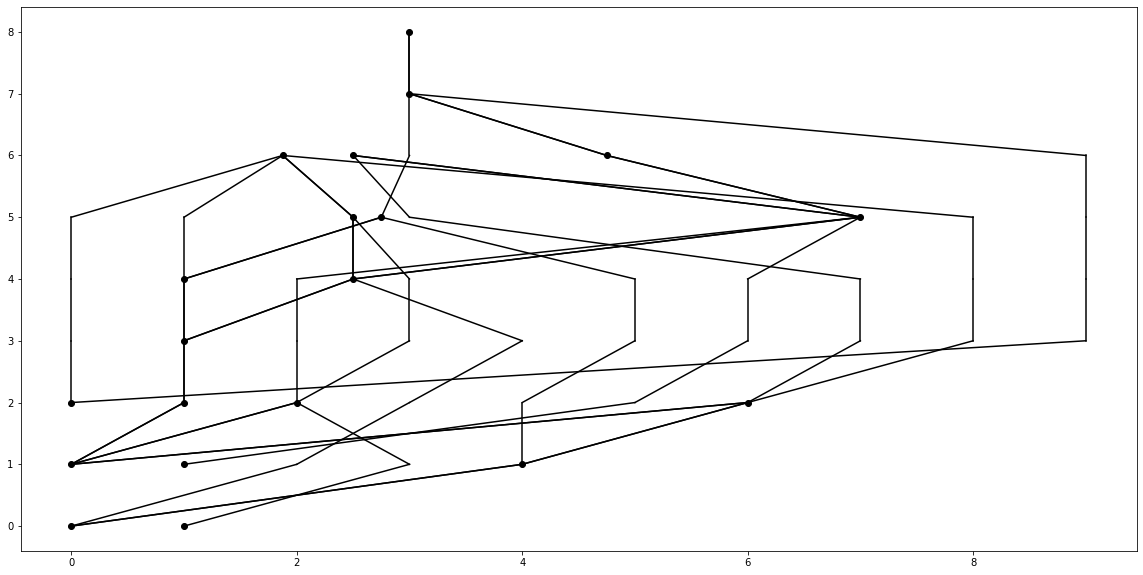

In [61]:
draw_graph("flow-20n.xml")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  # Remove the CWD from sys.path while we load stuff.


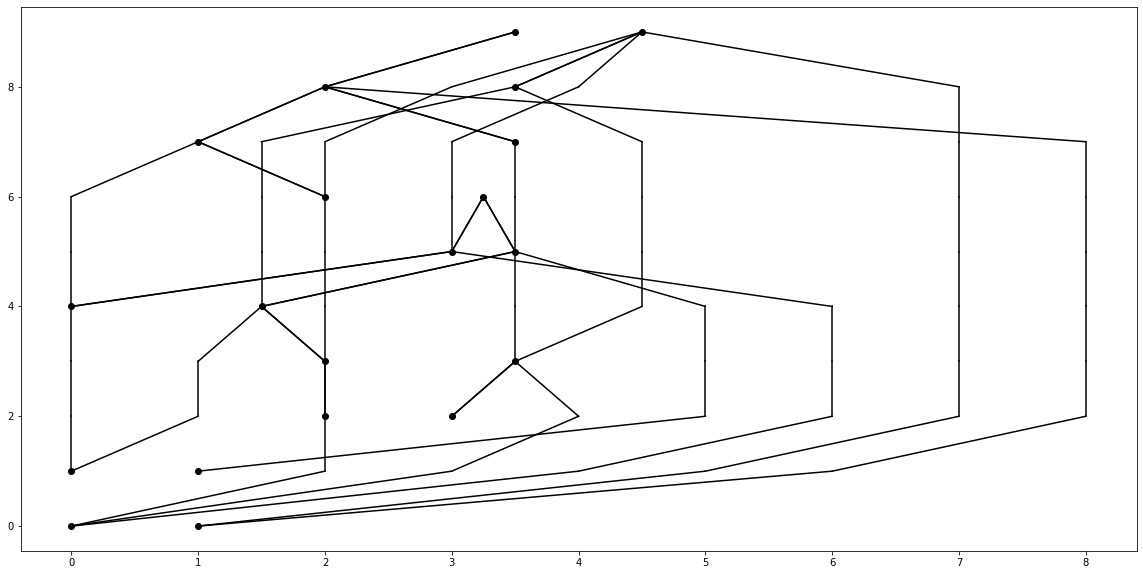

In [62]:
draw_graph("flow-20n.xml", W=2)